In [33]:
%matplotlib inline
import torch
import torch.nn as nn
import spacy
import gutenberg.acquire
import gutenberg.cleanup
import string
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [43]:
import pickle
import os

def read_or_pickle(path, load_default):
    path += '.pickle'
    if os.path.isfile(path):
        return pickle.load(open(path, 'rb'))
    else:
        data = load_default()
        pickle.dump(data, open(path, 'wb'))
        return data

def load_book(id):
    return gutenberg.cleanup.strip_headers(gutenberg.acquire.load_etext(id)).strip()

In [85]:
class CharRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        if model == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        else:
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size) 
                
    def forward(self, inp, hidden):
        batch_size = inp.size(0) 
        encoded = self.encoder(inp)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)

In [76]:
def char_tensor(chars, vocab):
    tensor = torch.zeros(len(chars), dtype=torch.long, device=device)
    for i, char in enumerate(chars):
        tensor[i] = vocab.index(char)
    return tensor 
        
def random_training_set(doc, vocab, chunk_len, batch_size):
    inp = torch.zeros(batch_size, chunk_len, dtype=torch.long, device=device)
    target = inp.clone()
    file_len = len(doc)
    
    for i in range(batch_size):
        start_index = random.randrange(file_len - (chunk_len + 1))
        end_index = start_index + chunk_len + 1
        chunk = doc[start_index:end_index]
        inp[i] = char_tensor(chunk[:-1], vocab)
        target[i] = char_tensor(chunk[1:], vocab) 

    return inp, target

In [88]:
def train(inp, target, net, criterion, optimizer, batch_size):
    hidden = net.init_hidden(batch_size)
    net.zero_grad()
    loss = 0
    
    for i in range(inp.size(1)):
        output, hidden = net(inp[:,i], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,i])
        
    loss.backward()
    optimizer.step()
    
    return loss.item() / inp.size(1)

In [103]:
def run_train(doc, vocab, net, criterion, optimizer, n_epochs, chunk_len, batch_size, plot_every=1):
    losses = []
    loss = 0

    for epoch in tqdm(range(n_epochs)):
        inp, target = random_training_set(doc, vocab, chunk_len,
                                          batch_size)
        loss += train(inp, target, net, criterion, optimizer, batch_size)

        if DEBUG:
            return

        if epoch % plot_every == 0:
            if LIVE_PLOT:
                liveloss.update({'loss': loss / plot_every})
                liveloss.draw()

            losses.append(loss / plot_every)
            loss = 0

    plt.figure()
    plt.plot(losses)
    
    print(f'Final loss: {losses[-1]}')

In [79]:
doc = load_book(84)
vocab = list(set(doc))

1.7989102172851563

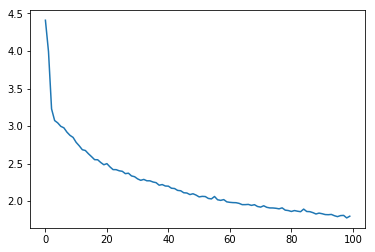

In [100]:
DEBUG = False
LIVE_PLOT = False
liveloss = PlotLosses()

hidden_size = 100
n_layers = 2
model = 'gru'
learning_rate = 0.01
n_epochs = 100
chunk_len = 200
batch_size = 100

net = CharRNN(len(vocab), hidden_size, len(vocab), model, n_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
run_train(doc, vocab, net, criterion, optimizer, n_epochs, chunk_len, batch_size)
torch.save(net.state_dict(), 'state.pt')

In [120]:
def sample(vocab, net, prime_str, predict_len, temperature, beam_number):
    with torch.no_grad(): 
        prime_str = list(prime_str)
        predicted = list(prime_str)
        
        hidden = net.init_hidden(1)
        prime_inp = char_tensor(prime_str, vocab).unsqueeze(0)
        for i in range(len(prime_str)):
            _, hidden = net(prime_inp[:,i], hidden)
        inp = prime_inp[:,-1]
        
        for i in range(predict_len):
            output, hidden = net(inp, hidden)
            
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]
        
            predicted_char = vocab[top_i]
            predicted.append(predicted_char)
            inp = char_tensor(predicted_char, vocab).unsqueeze(0)
        
        return predicted
        """
        beams = [(hidden, prime_str)]
        
        for i in range(max_length):
            output_pairs = []
            new_hidden = []
            for beami, (hidden, result) in enumerate(beams):
                tensor = input_tensor(result[-1], vocab)
                output, hidden = net(tensor, hidden)
                
                output_pairs += map(lambda pair: (pair[0], pair[1].item(), beami), enumerate(output[0][0]))
                new_hidden.append(hidden)
            
            output_pairs.sort(key=lambda pair: pair[1], reverse=True)
            
            new_beams = []
            for outi, _outv, beami in output_pairs[:beam_number]:
                result = list(beams[beami][1])
                
                if outi == len(vocab): # END TOKEN
                    output_sents.append(result)
                else:
                    char = vocab[outi]
                    result.append(char)
                    
                    if i == max_length - 1:
                        output_sents.append(result)
                    else:
                        new_beams.append((new_hidden[beami].clone(), result))
            beams = new_beams
            
        return list(map(''.join, output_sents))
        """

In [122]:
prime_str = 'Once upon a time'
predict_len = 100
temperature = 0.8
beam_number = 20

result = sample(vocab, net, prime_str, predict_len, temperature, beam_number)
print(''.join(result))

Once upon a time, I reman weould a solled by the spire her also crom, and her sestrave consher whellu more the sentu
